# MODEL V3

In [1]:
# import all libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import json 
import csv
import os
import datetime 
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn .compose import make_column_transformer

from keras.models import Sequential
from keras.layers import Dense

In [2]:
'''
Spotify OAuth to access API
'''
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
                    client_id="", 
                    client_secret=""))

## Load and clean training data

In [3]:
'''
Method to access Google location history file 'records.json'
Get the timestamp and location (lat, long) attributes
and save to csv file
'''
def process_location_history(file_path, data_writer):
    with open(file_path, encoding='utf-8-sig') as file:
        data = json.load(file)
        try:
            for obj in data['locations']:
                if 'timestamp' in obj:
                    timestamp = obj['timestamp']
                    try:
                        datetime_obj = datetime.datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%SZ')
                    except ValueError:
                        datetime_obj = datetime.datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.%fZ')
                    
                    ts_format = "%Y-%m-%d %H:%M:%S"
                    ts = datetime_obj.strftime(ts_format)
                    lat = obj['latitudeE7'] / 10**7
                    lon = obj['longitudeE7'] / 10**7
                    data_writer.writerow([ts, lat, lon])
        except KeyError:
                print('\r',end=" ")

In [4]:
'''
Convert Spotify timestamp format to match location data
'''
def convert_timestamp(timestamp_str):
    timestamp_obj = datetime.datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%SZ")
    new_format = "%Y-%m-%d %H:%M:%S"
    formatted_timestamp = timestamp_obj.strftime(new_format)
    return formatted_timestamp

In [5]:
'''
Read listening history json records into single dataframe
'''
def process_listening_history(root_dir):
    list_hist_files = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".json"):
                # append each listening history file to a list file to be loaded
                file_path = os.path.join(subdir, file)
                list_hist_files.append(file_path)

    # load all files into a single dataframe
    frames = [pd.read_json(f) for f in list_hist_files]
    listening_df = pd.concat(frames, ignore_index=True, sort=True)

    # Remove columns that wont be obtainable through 'Get recently played tracks' API call
    column_to_remove = ['username', 'platform', 'ip_addr_decrypted', 'user_agent_decrypted', 
                        'master_metadata_track_name', 'master_metadata_album_artist_name',
                        'master_metadata_album_album_name', 'episode_name', 'episode_show_name',
                        'spotify_episode_uri', 'shuffle',  'offline', 'offline_timestamp',
                        'incognito_mode', 'skipped', 'reason_start', 'reason_end']
    listening_df.drop(labels=column_to_remove, axis=1, inplace=True)
    
    # Only get listening history for songs in listened to SG
    listening_df = listening_df[listening_df['conn_country'] == 'SG']
    listening_df.drop(labels='conn_country', axis=1, inplace=True)
    
    # convert  timestamp to match location history
    listening_df['ts'] = listening_df['ts'].apply(lambda x: convert_timestamp(x))
    
    return listening_df

In [6]:
# Load data

# Read location records into a dataframe
location_json_file = os.path.join(os.getcwd() + "/Training_Data/Records.json")
location_csv_file = os.path.join(os.getcwd() + "/Training_Data/ferozLocationHistory.csv")

with open(location_csv_file, 'w', newline='') as outfile:
    data_writer = csv.writer(outfile)
    data_writer.writerow(["ts", "lat", "lon"])
    process_location_history(location_json_file, data_writer)
location_df = pd.read_csv(location_csv_file)

# Read listening history files into a dataframe
root_dir = os.path.join(os.getcwd() +"/Training_Data/MySpotifyExtendedData")
listening_df = process_listening_history(root_dir)

# drop null rows
listening_df = listening_df.dropna(axis=0)

# sort both dataframes by ts
listening_df.sort_values(by='ts',axis=0,inplace=True)
location_df.sort_values(by='ts',axis=0,inplace=True)

In [7]:
'''
Convert timestamp to nearest minute
'''
def convert_timestamp_to_nearest_min(timestamp_str):
    timestamp_obj = datetime.datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S")
    new_format = "%Y-%m-%d %H:%M"
    formatted_timestamp = timestamp_obj.strftime(new_format)
    return formatted_timestamp

In [8]:
# Convert timestamp to nearest minute
listening_df['ts'] = listening_df['ts'].apply(lambda x: convert_timestamp_to_nearest_min(x))
location_df['ts'] = location_df['ts'].apply(lambda x: convert_timestamp_to_nearest_min(x))

# Merge the two tables based on timestamp
merged_df = pd.merge(listening_df, location_df, on='ts', how='outer')

# Drop null rows (i.e. rows without matching location/listening record)
merged_df.dropna(axis=0, inplace=True)

# Drop duplicate rows
merged_df.drop_duplicates(keep='first', inplace=True)

In [9]:
'''
Get track attributes for all unique songs from spotify API
'''
def getTrackAttributes(tracks, batch_size):
    
    # Split track list to batches of 100 unique songs due to API constraints
    track_batches = [tracks[i: i+batch_size] for i in range(0, len(tracks), batch_size)]

    # Empty list to store track features
    track_features = [] 

    # Get track features in batches and add to end of list
    for batch in track_batches:
        batch_track_features = sp.audio_features(batch)
        track_features.extend(batch_track_features)

    return pd.DataFrame(track_features)

In [10]:
# Get list of unique songs 
track_list = merged_df['spotify_track_uri'].unique().tolist()

# Get track attributes
track_features_df = getTrackAttributes(track_list, 100)

# Drop columns which are meta info about track features
track_features_df.drop(labels=['type','id','track_href','analysis_url'], 
                        axis=1, 
                        inplace=True)

# Rename to match merged df naming convention
track_features_df.rename(columns={'uri':'spotify_track_uri'}, inplace=True)

# Merge with main dataframe
merged_df = pd.merge(left=merged_df,
                    right=track_features_df,
                    on='spotify_track_uri',
                    how='left',
                    suffixes=("_x", "_y"))

# Get how long the song was played based on time played / cong length
merged_df['percentage_played'] = (merged_df['ms_played'] / merged_df['duration_ms'] * 1.00)

# Set threshold as 0.95 (i.e. if you listened to 95% of the sing -> you liked it)
# Only accept songs that were were played up to 95% of song length
threshold = 0.95 
merged_df = merged_df[merged_df['percentage_played'] >= threshold]

# Drop unnecessary columns once done
drop_columns = ['percentage_played', 'ms_played', 'duration_ms', 'spotify_track_uri']
merged_df.drop(labels=drop_columns, inplace=True, axis=1)                    

In [11]:
# Round the location to 3 decimal places
merged_df['lat'] = merged_df['lat'].apply(lambda x:round(x, 3))
merged_df['lon'] = merged_df['lon'].apply(lambda x:round(x, 3))

In [13]:
merged_df.shape

(5452, 15)

In [16]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lat,5452.0,1.357764,0.516754,1.263000,1.312000,1.319500,1.351000,10.817
lon,5452.0,103.803853,0.191631,101.708000,103.706000,103.846000,103.852000,106.699
danceability,5452.0,0.549066,0.148806,0.070500,0.449000,0.552000,0.657000,0.982
energy,5452.0,0.513911,0.207483,0.002900,0.361000,0.502000,0.662000,0.995
key,5452.0,5.193874,3.527809,0.000000,2.000000,5.000000,8.000000,11.000
loudness,5452.0,-8.094598,3.327246,-34.716000,-9.684000,-7.618500,-5.836000,0.915
mode,5452.0,0.763756,0.424812,0.000000,1.000000,1.000000,1.000000,1.000
speechiness,5452.0,0.073958,0.087156,0.022200,0.032600,0.041000,0.069300,0.934
acousticness,5452.0,0.417138,0.327248,0.000006,0.083525,0.392000,0.736000,0.996
instrumentalness,5452.0,0.048189,0.171201,0.000000,0.000000,0.000006,0.000594,0.966


In [14]:
merged_df.head()

,ts,lat,lon,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
9,2017-11-02 10:32,1.280,103.850,0.603,0.557,0,-6.863,1,0.0659,0.20400,0.000564,0.0998,0.301,99.845,4
11,2017-11-02 10:39,1.282,103.849,0.570,0.289,3,-8.854,1,0.0687,0.84300,0.000000,0.1300,0.339,81.566,4
24,2017-11-02 12:29,1.313,103.849,0.465,0.896,2,-3.126,1,0.0795,0.00725,0.000000,0.2060,0.569,181.014,4
25,2017-11-02 12:29,1.312,103.848,0.465,0.896,2,-3.126,1,0.0795,0.00725,0.000000,0.2060,0.569,181.014,4
38,2017-11-03 00:30,1.326,103.890,0.688,0.375,2,-10.066,0,0.0398,0.40500,0.259000,0.0992,0.214,100.014,4


In [15]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5452 entries, 9 to 16723
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ts                5452 non-null   object 
 1   lat               5452 non-null   float64
 2   lon               5452 non-null   float64
 3   danceability      5452 non-null   float64
 4   energy            5452 non-null   float64
 5   key               5452 non-null   int64  
 6   loudness          5452 non-null   float64
 7   mode              5452 non-null   int64  
 8   speechiness       5452 non-null   float64
 9   acousticness      5452 non-null   float64
 10  instrumentalness  5452 non-null   float64
 11  liveness          5452 non-null   float64
 12  valence           5452 non-null   float64
 13  tempo             5452 non-null   float64
 14  time_signature    5452 non-null   int64  
dtypes: float64(11), int64(3), object(1)
memory usage: 681.5+ KB


Text(0.5, 1.0, 'Track_feature_heatmap')

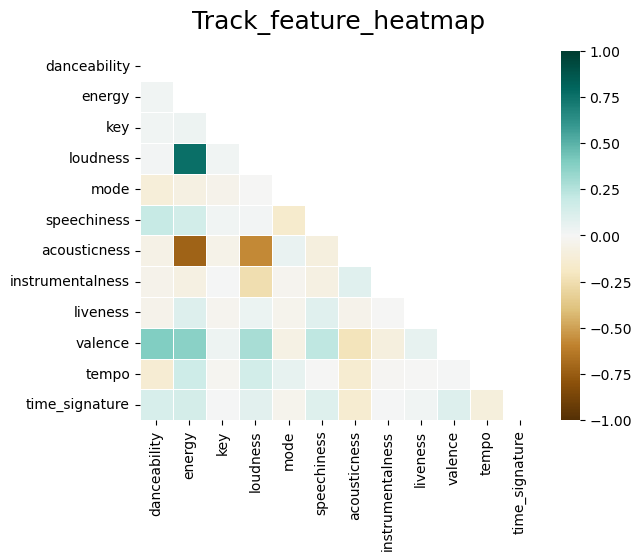

<Figure size 1600x800 with 0 Axes>

In [17]:
# Check VIF of track attributes for any strong multicollinearity

import matplotlib.pyplot as plt
import seaborn as sns

track_features = merged_df[['danceability', 'energy', 'key', 'loudness', 'mode',
                    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                    'valence', 'tempo', 'time_signature']]


mask = np.triu(np.ones_like(track_features.corr(), dtype=bool))
heatmap = sns.heatmap(track_features.corr(), mask = mask, vmin= -1, vmax = 1, cmap='BrBG', linewidth=.5)

plt.figure(figsize=(16,8))
heatmap.set_title('Track_feature_heatmap', fontdict={'fontsize':18}, pad=16)

In [19]:
merged_df.columns

Index(['ts', 'lat', 'lon', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

In [54]:
# save as CSV file
merged_df.to_csv('train_data.csv', index=False)

## Feature engineering

In [14]:
'''
Convert timestamp to hour only
'''
def hour_block(hour):
    result = (hour + 8) % 23
    return result // 4

In [15]:
'''
Convert timestamp to hour only
'''
def hour_block(hour):
    result = (hour + 8) % 23
    return result // 4

'''
OHE timestamp to blocks of 4 hour 
''' 
def fe_timestamp(df):
    df['hour'] = pd.DatetimeIndex(df['ts']).hour
    df['time_fe'] = df['hour'].apply(hour_block).astype(object)
    

In [51]:
'''
Assign cartesian coordinate (latitude, longitude) to a grid cell in grid table
'''

def fe_coordinates(df):

    # Set boundaries for Singapore
    lonmin = 101.333
    lonmax = 104.412
    latmin = 1.083
    latmax = 4.0
    
    # Create grid cells
    grid_size = 0.1
    lat_bins = pd.interval_range(start=latmin,end=latmax, freq=grid_size)
    lon_bins = pd.interval_range(start=lonmin,end=lonmax, freq=grid_size)

    # Method to round the label to nearest 2 decimal
    def round_interval_label(label):
        return round(label.left, 2)
    
    # Round the label 
    rounded_lat_label = (pd.cut(df['lat'], bins=lat_bins, labels=False)
                      .apply(round_interval_label))
    rounded_lon_label = (pd.cut(df['lon'], bins=lon_bins, labels=False)
                      .apply(round_interval_label))

    # assign coordinate to grid cell
    df['location_fe'] = (rounded_lat_label.astype(str) +
                        '_' +  
                        rounded_lon_label.astype(str))
    
    # Remove location records with 'nan_nan' after feature engineering
    # df.drop(df[df['location_fe_nan_nan'] == True].index, inplace=True)
    def remove_nana_from_location(df):
        df.drop(df[df['location_fe'] == 'nan_nan'].index, inplace=True)
    remove_nana_from_location(df)


In [46]:
# Remove location records with 'nan_nan' after feature engineering

def remove_nana_from_location(df):
    df.drop(df[df['location_fe'] == 'nan_nan'].index, inplace=True)

In [52]:
'''
Perform FE
'''
# make copy of df 
df_copy = merged_df.copy(deep=True)

# perform fe on timestamp
fe_timestamp(df=df_copy)

# perform fe on coordinates
fe_coordinates(df=df_copy)

# Drop null columns from feature engineered location
# remove_nana_from_location(df=df_copy)

# drop original columns
original_columns = ['ts','lat','lon','hour']
df_copy.drop(labels=original_columns, inplace=True, axis=1)

# perform ohe on fe columns
df = pd.get_dummies(data= df_copy, columns=['time_fe','location_fe'])

# reset index
df.reset_index(level=None, drop=True, inplace=True)

df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,location_fe_1.98_102.88,location_fe_1.98_102.99,location_fe_2.08_102.68,location_fe_2.08_102.78,location_fe_2.18_102.57,location_fe_2.38_102.06,location_fe_2.38_102.16,location_fe_2.68_101.75,location_fe_2.88_101.75,location_fe_2.98_101.64
0,0.603,0.557,0,-6.863,1,0.0659,0.20400,0.000564,0.0998,0.301,...,False,False,False,False,False,False,False,False,False,False
1,0.570,0.289,3,-8.854,1,0.0687,0.84300,0.000000,0.1300,0.339,...,False,False,False,False,False,False,False,False,False,False
2,0.465,0.896,2,-3.126,1,0.0795,0.00725,0.000000,0.2060,0.569,...,False,False,False,False,False,False,False,False,False,False
3,0.465,0.896,2,-3.126,1,0.0795,0.00725,0.000000,0.2060,0.569,...,False,False,False,False,False,False,False,False,False,False
4,0.688,0.375,2,-10.066,0,0.0398,0.40500,0.259000,0.0992,0.214,...,False,False,False,False,False,False,False,False,False,False


In [53]:
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'time_fe_0', 'time_fe_1', 'time_fe_2', 'time_fe_3',
       'time_fe_4', 'time_fe_5', 'location_fe_1.18_103.71',
       'location_fe_1.18_103.82', 'location_fe_1.28_103.61',
       'location_fe_1.28_103.71', 'location_fe_1.28_103.82',
       'location_fe_1.28_103.92', 'location_fe_1.38_103.71',
       'location_fe_1.38_103.82', 'location_fe_1.58_103.4',
       'location_fe_1.68_103.4', 'location_fe_1.88_103.09',
       'location_fe_1.88_103.2', 'location_fe_1.98_102.88',
       'location_fe_1.98_102.99', 'location_fe_2.08_102.68',
       'location_fe_2.08_102.78', 'location_fe_2.18_102.57',
       'location_fe_2.38_102.06', 'location_fe_2.38_102.16',
       'location_fe_2.68_101.75', 'location_fe_2.88_101.75',
       'location_fe_2.98_101.64'],
      dtype='object')

## Clustering approach

In [21]:
'''
Use K-means clustering to assign listening record to a cluster
'''
import plotly.express as px

trial_df = df.copy(deep=True)

# Drop the target features
target_columns = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                'valence', 'tempo', 'time_signature']
cluster_df = trial_df.drop(labels=target_columns,axis=1)

# Find the optimal k value
wcss = []
for K in range(1, 20):
    kmeans_model = MiniBatchKMeans(n_clusters=K, 
                                   init='k-means++',
                                   random_state=42,
                                   n_init='auto')
    kmeans_model.fit(cluster_df)
    wcss.append(kmeans_model.inertia_)
    
# Use the Elbow method
fig = px.line(x=range(1, 20), y=wcss, title='Elbow Plot', labels={'x':'No. of Clusters', 'y':'wcss'})
fig.show()

In [22]:
'''
Check the track attributes based on cluster
'''
# Get only the spatial and time data for model training
target_columns = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                'valence', 'tempo', 'time_signature']
cluster_df = df.drop(labels=target_columns,axis=1)

# Generate the clusters
model = MiniBatchKMeans(n_clusters=8, 
                        init='k-means++',
                        random_state=42,
                        n_init='auto')
y_means = model.fit_predict(cluster_df)

# Append clustering to dataframe
df['clusters'] = y_means.astype(int)

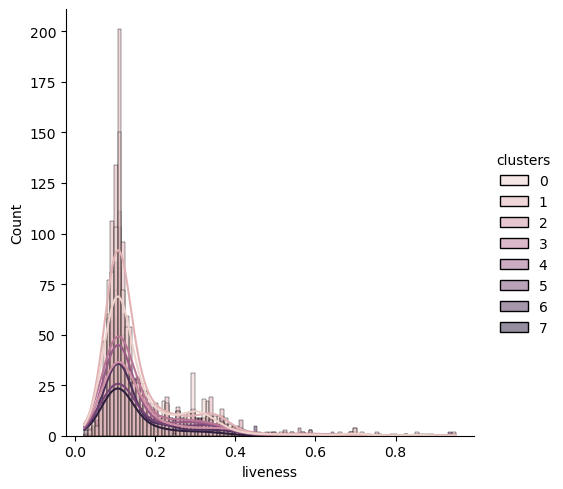

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

target_columns = ['danceability', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']

sns.displot(data=df, x='liveness', hue='clusters', kde=True)
plt.show()

In [31]:
# Get average value for each attribute given cluster

track_df = df.copy(deep=True)

target_columns = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                'valence', 'tempo', 'time_signature']

for i in range(len(track_df.clusters.unique())):
    cluster_data = track_df[track_df['clusters'] == i]
    average_values = np.mean(cluster_data[target_columns], axis=0)
    print('average for cluster {} is: \n{} '.format(i, average_values))

average for cluster 0 is: 
danceability          0.567696
energy                0.487490
key                   5.216463
loudness             -8.459706
mode                  0.732724
speechiness           0.079967
acousticness          0.463455
instrumentalness      0.057009
liveness              0.165521
valence               0.351334
tempo               116.887975
time_signature        3.922764
dtype: float64 
average for cluster 1 is: 
danceability          0.548922
energy                0.531598
key                   5.349791
loudness             -7.784992
mode                  0.766527
speechiness           0.072832
acousticness          0.378872
instrumentalness      0.042415
liveness              0.160319
valence               0.367406
tempo               119.272278
time_signature        3.884519
dtype: float64 
average for cluster 2 is: 
danceability          0.576614
energy                0.517984
key                   5.293624
loudness             -8.294227
mode               

## Classification approach

In [ ]:
# split target variables to continuous and discrete 
cont_targets = []
disc_targets = []

In [ ]:
'''
Try predict track attributes based on random forest regression model
'''



In [ ]:
'''
Try predict track attributes based on random forest classification model
'''



## Spotify track attributes guideline

<div class="alert alert-block alert-info">

- <b> Continuous variable (0 - 1.0): </b>
    - danceability
    - energy
    - acousticness
    - instrumentalness (value above 0.5 indicates instrumental track)
    - liveness
    - speechiness (values above 0.6 likely fully spoken word)
    - valence
    - tempo (average beat duration)
<br/><br/>
- <b> Discrete variables: </b>
    - key (1 - 11, else -1)
    - mode (0 / 1)
    - time_signature (3-7)
    - loudness (typically -60 to 0)
</div>

## FINAL METHODS

In [ ]:
'''
Get 5 seed tracks from user_history
'''
def get_seed_tracks(df, timestamp):
    # split date-time to individual parts
    df['ts'] = df['ts'].apply(lambda x: convert_timestamp_to_nearest_min(x))
    df['month'] = pd.DatetimeIndex(df["ts"]).month
    df['weekday'] = pd.DatetimeIndex(df["ts"]).weekday
    df['hour'] = pd.DatetimeIndex(df["ts"]).hour
    df['min'] = pd.DatetimeIndex(df["ts"]).minute
    
    # Extract the month, weekday, and hour from the given timestamp
    given_timestamp =  pd.to_datetime(timestamp)
    given_month = given_timestamp.month()
    given_weekday = given_timestamp.weekday()
    given_hour = given_timestamp.hour()
    given_minute = given_timestamp.minute()

    # Calculate the absolute time differences between the given timestamp and each row in the dataframe
    df['time_diff'] = (abs(df['month'] - given_month) + abs(df['weekday'] - given_weekday) + 
                       abs(df['hour'] - given_hour) + abs(df['min'] - given_minute))

    # Sort the dataframe by the time differences in ascending order
    df_sorted = df.sort_values('time_diff')

    # Get the 5 rows with the closest matching timestamps
    closest_rows = df_sorted.head(5)

    # Remove created columns
    columns = ['ts','month','weekday','hour','min','time_diff']
    df.drop(labels=columns,inplace=True,axis=1)

    return closest_rows['track_id']

In [ ]:
'''
Pre-process user listening history data

format: id // userid // latitude // longitude // spotify_track_id // timestamp
'''
def preprocess_data(user_history):
    # convert timestamp to nearest minute
    user_history['timestamp'] = user_history['timestamp'].apply(lambda x: convert_timestamp_to_nearest_min(x))
    
    # Get list of unique songs 
    track_list = user_history['spotify_track_id'].unique().tolist()

    # Get track attributes
    track_features_df = getTrackAttributes(track_list, 100)

    # Drop columns which are meta info about track features
    track_features_df.drop(labels=['type','uri','track_href','analysis_url'], 
                            axis=1, 
                            inplace=True)

    # Rename to match merged df naming convention
    track_features_df.rename(columns={'uri':'spotify_track_id'}, inplace=True)

    # Merge with main dataframe
    merged_df = pd.merge(left = user_history,
                    right = track_features_df,
                    on='spotify_track_id',
                    how='left')
    
    # Drop track_id once merged
    merged_df.drop(labels='spotify_track_id', inplace=True, axis=1)                    
    
    return merged_df


In [ ]:
'''
Do feature engineering on the dataframe before fit into model
'''

def perform_FE(df):
    # perform fe on timestamp
    fe_timestamp(df=df)

    # perform fe on coordinates
    fe_coordinates(df=df)

    # drop original columns
    original_columns = ['timestamp','latitude','longitude','hour']
    df.drop(labels=original_columns, inplace=True, axis=1)

    # perform OHE on FE columns
    df = pd.get_dummies(data=df, columns=['time_fe','location_fe'])

    # reset index
    df.reset_index(level=None, drop=True, inplace=True)

    return df

In [ ]:
'''
Make new prediction given pre-processed user listening history

df = user history
model = base model
cur_request = array of current timestamp & location
'''
def predict_song_attributes(df, model, cur_request):

    # fit user data to loaded base model
    model.partial_fit(df)
    
    # predict clusters for user data
    y_means = model.predict(df)
    
    # append clusters to user history
    df['clusters'] = y_means.astype(int)

    # predict cluster allocation for request
    i = model.predict(cur_request)

    # find average value given the predicted cluster
    cluster_data = df[df['clusters'] == i]
    average_values = np.mean(cluster_data, axis=0)

    # return average value
    return average_values

In [ ]:
'''
Form JSON response with min/max values for track attributes with seed tracks
'''
def form_recommendation(seed_tracks, track_attributes):

    # adjust the track attribute target to follow spotify guideline
    
    # update with the min and max value for each attribute
    